In [178]:
import pandas as pd
import numpy as np
import s3fs

In [179]:
fs = s3fs.S3FileSystem()
s3_location = "s3://ecb-hackathon-data-group08-x19s00/climate_data_full/absorbed_photosynthetically_active_radiation_anomaly/"
all_files = fs.ls(s3_location)


all_dfs = []

for file in all_files:
    if file.endswith("csv"):
        file_name = file.split("/")[-1]
        year = file_name.split("_")[-1].split(".")[0]
        
        fapar_yearly = pd.read_csv(f"s3://{file}")
        fapar_yearly["year"] = year
        # column names has whitespaces around
        fapar_yearly.rename(columns=lambda x: x.strip(), inplace=True)
        all_dfs.append(fapar_yearly)
        

fapar_aggregated = pd.concat(all_dfs)
fapar_aggregated.dropna(subset=['MEDIAN'], inplace=True)


# calculate standard deviation per year
additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'MEDIAN':'std'})
additional_variable = additional_variable.add_suffix('_std')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])


# calculate mean per year
additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'MEDIAN':'mean'})
additional_variable = additional_variable.add_suffix('_mean')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])

# calculate median per year
additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'MEDIAN':'median'})
additional_variable = additional_variable.add_suffix('_median')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])

# calculate min per year
additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'MEDIAN':'min'})
additional_variable = additional_variable.add_suffix('_min')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])

# sum months of low radiation activity
fapar_aggregated['fapar_low_months_to_remove'] = np.where(fapar_aggregated['MEDIAN'] < -1, 1, 0)
#fapar_sum = fapar_data[i].groupby(['NUTS_ID', 'year']).sum('fapar_low_months').reset_index()

additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'fapar_low_months_to_remove':'sum'})
additional_variable = additional_variable.add_suffix('_new')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])

# sum months of severe low radiation activity
fapar_aggregated['fapar_severe_low_months_to_remove'] = np.where(fapar_aggregated['MEDIAN'] <= -2, 1, 0)
#fapar_sum_severe = fapar_data[i].groupby(['NUTS_ID', 'year']).sum('fapar_severe_low_months').reset_index()

additional_variable = fapar_aggregated.groupby(['NUTS_ID', 'year']).agg({'fapar_severe_low_months_to_remove':'sum'})
additional_variable = additional_variable.add_suffix('_new')
fapar_aggregated = pd.merge(fapar_aggregated,additional_variable,on=['NUTS_ID', 'year'])

# rewrite column names
fapar_aggregated = fapar_aggregated.rename(columns={
                                "fapar_severe_low_months_to_remove_new": "fapar_severe_low_months", 
                                "fapar_low_months_to_remove_new": "fapar_low_months"})
fapar_aggregated = fapar_aggregated.drop(['MEDIAN', 'fapar_severe_low_months_to_remove', 'fapar_low_months_to_remove'], axis=1)
fapar_aggregated.columns = [str(col).replace("MEDIAN", "fapar")  for col in fapar_aggregated.columns]



In [180]:
# lets create yearly data. Just use any of  max or min function as it is already calculated for yearly data
f = {'fapar_std': 'min',
     'fapar_mean': 'min',
     'fapar_median': 'min',
     'fapar_min': 'min', 
     'fapar_low_months': 'min', 
     'fapar_severe_low_months': 'min'}
fapar_aggregated = fapar_aggregated.groupby(['NUTS_ID', 'year'], as_index=False).agg(f)

fapar_aggregated


NUTS_ID  year  fapar_std  fapar_mean  fapar_median  fapar_min  \
0          AD  2012   0.816507    0.075833       -0.0960     -1.177   
1          AD  2013   0.889467   -0.151750       -0.2465     -1.400   
2          AD  2014   0.780246    0.313833        0.4185     -0.972   
3          AD  2015   0.593244    0.697833        0.8060     -0.420   
4          AD  2016   0.500969    0.948583        0.9365      0.247   
...       ...   ...        ...         ...           ...        ...   
15912   UKN0G  2018   0.662550    0.131200        0.0895     -0.879   
15913   UKN0G  2019   0.486562   -0.273400       -0.3335     -0.965   
15914   UKN0G  2020   0.692918    0.446667        0.7510     -0.664   
15915   UKN0G  2021   0.526376    0.112800        0.2050     -0.658   
15916   UKN0G  2022   0.814529    0.505100        0.4720     -0.705   

       fapar_low_months  fapar_severe_low_months  
0                     1                        0  
1                     1                        0  
2                     0                        0  
3                     0                        0  
4                     0                        0  
...                 ...                      ...  
15912                 0                        0  
15913                 0                        0  
15914                 0                        0  
15915                 0                        0  
15916                 0                        0  

[15917 rows x 8 columns]

In [181]:
# save data in csv format
fapar_aggregated.to_csv("fapar_aggregated.csv", index=False)

In [182]:
# check correlation of variables
fapar_aggregated_corr = fapar_aggregated.drop(['NUTS_ID', 'year'], axis=1)
matrix = fapar_aggregated_corr.corr()
print(matrix)

                         fapar_std  fapar_mean  fapar_median  fapar_min  \
fapar_std                 1.000000   -0.189342     -0.105556  -0.761175   
fapar_mean               -0.189342    1.000000      0.920109   0.627561   
fapar_median             -0.105556    0.920109      1.000000   0.456008   
fapar_min                -0.761175    0.627561      0.456008   1.000000   
fapar_low_months          0.564336   -0.636818     -0.519721  -0.713200   
fapar_severe_low_months   0.492288   -0.191292     -0.101990  -0.553834   

                         fapar_low_months  fapar_severe_low_months  
fapar_std                        0.564336                 0.492288  
fapar_mean                      -0.636818                -0.191292  
fapar_median                    -0.519721                -0.101990  
fapar_min                       -0.713200                -0.553834  
fapar_low_months                 1.000000                 0.321272  
fapar_severe_low_months          0.321272                 1.

In [183]:
# plot SMA on maps
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

%matplotlib inline

def plotDfAsMap(df,columnname,title):
    #ax= df.plot(figsize=(10,10))
    ax=df.plot(cmap='RdBu',column=columnname)
    minx, miny, maxx, maxy = 20e5, 10e5, 80e5, 70e5
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.margins(0)
    ax.set_title(title)
    plt.show()

# https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [184]:
#Read shapefiles
world_data = gpd.read_file(r's3://ecb-hackathon-data-group08-x19s00/economic_data_full/regional_boundaries/NUTS_RG_20M_2021_3035.shp') 
world_data = world_data[world_data.LEVL_CODE==3]

# try to combine with dataset

world_data.sort_values(by=['NUTS_ID'])
#world_data.insert(0, "NUTS_CODE", world_data['NUTS_ID'])
#world_data['NUTS_CODE'] = world_data['NUTS_ID']
year = '2012'
fapar_aggregated_selection = fapar_aggregated[fapar_aggregated.year==year]
plot_data = pd.merge(world_data,fapar_aggregated_selection,on=['NUTS_ID'],how='right')

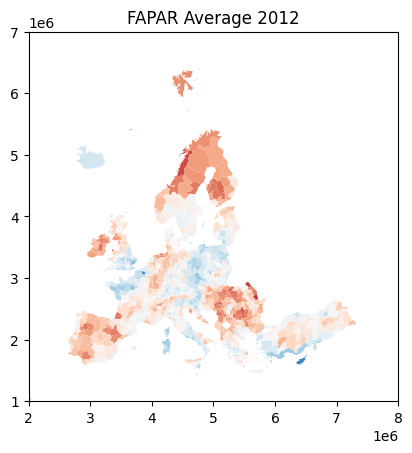

In [185]:
plotDfAsMap(plot_data,'fapar_mean', 'FAPAR Average 2012')

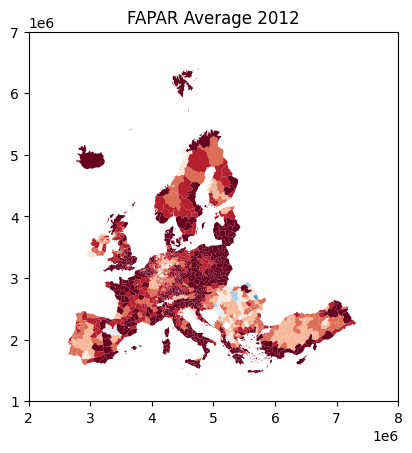

In [186]:
plotDfAsMap(plot_data,'fapar_low_months', 'FAPAR Average 2012')